## 1. Import Package

In [1]:
!pip install scikeras

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import uniform

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Keras
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from scikeras.wrappers import KerasClassifier

import tensorflow as tf

2024-08-24 06:45:55.800298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 06:45:55.823120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 06:45:55.829924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 06:45:57.030335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from keras import backend as K

In [4]:
import warnings
warnings.filterwarnings("ignore")

## 2. Data
### 2.1 Raw Data

In [5]:
df = pd.read_csv('new_merged.csv')

In [6]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TIMESTAMP')

### 2.2 Features

In [7]:
df['log_return'] = np.log(df['CLOSE']/df['CLOSE'].shift(1))

In [8]:
## Features Related to Returns, AMOUNT and Volatility up to past 120 ticks
for i in range(5, 125, 5):
    df['log_return_'+str(i)] = df['log_return'].rolling(window=i).sum()

df['liquidity_log_return'] = np.log(df['LIQUIDITYPRICE_pepe']/df['LIQUIDITYPRICE_pepe'].shift(1))
for i in range(5, 125, 5):
    df['liquidity_log_return_'+str(i)] = df['liquidity_log_return'].rolling(window=i).sum()

for i in range(5, 125, 5):
    df['AMOUNT_pepe_'+str(i)] = df['AMOUNT_pepe'].rolling(window=i).mean()

for i in range(5, 125, 5):
    df['AMOUNT_weth_'+str(i)] = df['AMOUNT_weth'].rolling(window=i).mean()

df = df.copy()
for i in range(5, 125, 5):
    df['vol_'+str(i)] = df['log_return'].rolling(window=i).std()*np.sqrt(i)

In [9]:
df = df.drop(columns = ['OPEN','CLOSE', 'HIGH', 'LOW', 'VOLUME','LIQUIDITYPRICE_pepe', 'AMOUNT_pepe', 'AMOUNT_weth'])

In [10]:
df.head()

,log_return,log_return_5,log_return_10,log_return_15,log_return_20,log_return_25,log_return_30,log_return_35,log_return_40,log_return_45,...,vol_75,vol_80,vol_85,vol_90,vol_95,vol_100,vol_105,vol_110,vol_115,vol_120
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2024-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 00:06:00,-0.002108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 00:07:00,0.006779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 00:12:00,-0.005319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 00:15:00,0.006859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.shape

(7869, 122)

In [12]:
df['return_label'] = df['log_return'].shift(-1).rolling(window = 1).sum()
df['label'] = np.where(df['return_label']>0, 1, 0)

In [13]:
df = df.copy()
df = df.dropna()

### 2.3 Plot

In [14]:
# df.iloc[:, :25].plot(subplots = True, color = 'blue', figsize = (20,20))

### 2.4 Correlation Matrix

In [15]:
#

## 3. Model
### 3.1 Separate Test Data and Generate Different Model

In [16]:
## Baseline Model 1: Log Return
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df.iloc[:, :25], df.iloc[:, 123], test_size = 0.1, shuffle=False, stratify=None)
### LSTM
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_1_lstm=X_train_1.values.reshape(X_train_1.shape[0], 1, X_train_1.shape[1])
X_test_1_lstm=X_test_1.values.reshape(X_test_1.shape[0], 1, X_test_1.shape[1])

## Model 2: Log Return + Volatility
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(pd.concat([df.iloc[:, :25], df.iloc[:, 98:122]], axis = 1), df.iloc[:, 123], test_size = 0.1, shuffle=False, stratify=None)
### LSTM
X_train_2_lstm=X_train_2.values.reshape(X_train_2.shape[0], 1, X_train_2.shape[1])
X_test_2_lstm=X_test_2.values.reshape(X_test_2.shape[0], 1, X_test_2.shape[1])

## Model 3: Log Return + Liquidity Return + Volatility
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(pd.concat([df.iloc[:, :50], df.iloc[:, 98:122]], axis = 1), df.iloc[:, 123], test_size = 0.1, shuffle=False, stratify=None)
X_train_3_lstm=X_train_3.values.reshape(X_train_3.shape[0], 1, X_train_3.shape[1])
X_test_3_lstm=X_test_3.values.reshape(X_test_3.shape[0], 1, X_test_3.shape[1])

## Model 4: Log Return + Liquidity Return + AMOUNT
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(df.iloc[:, :98], df.iloc[:, 123], test_size = 0.1, shuffle=False, stratify=None)

X_train_4_lstm=X_train_4.values.reshape(X_train_4.shape[0], 1, X_train_4.shape[1])
X_test_4_lstm=X_test_4.values.reshape(X_test_4.shape[0], 1, X_test_4.shape[1])

## Model 5: Log Return + Liquidity Return + AMOUNT + Volatility
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(df.iloc[:, :122], df.iloc[:, 123], test_size = 0.1, shuffle=False, stratify=None)

X_train_5_lstm=X_train_5.values.reshape(X_train_5.shape[0], 1, X_train_5.shape[1])
X_test_5_lstm=X_test_5.values.reshape(X_test_5.shape[0], 1, X_test_5.shape[1])

## Model 6: Log Return + Liquidity Return
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(df.iloc[:, :50], df.iloc[:, 123], test_size = 0.1, shuffle=False, stratify=None)
X_train_6_lstm=X_train_6.values.reshape(X_train_6.shape[0], 1, X_train_6.shape[1])
X_test_6_lstm=X_test_6.values.reshape(X_test_6.shape[0], 1, X_test_6.shape[1])

### 3.2 Label Distribution

In [17]:
print("Train Set Label 1:{}".format(np.mean(y_train_4==1)))
print("Test Set Label 1:{}".format(np.mean(y_test_4==1)))

Train Set Label 1:0.5826760361393948
Test Set Label 1:0.6103225806451613


## 4. Models
### 4.1 LSTM Model

In [18]:
def create_lstm(epochs=1,
                LSTM_units=1,
                num_samples=1,
                look_back=1,
                num_features=None,
                dropout_rate=0,
                recurrent_dropout=0,
                verbose=0):
    K.clear_session()
    model = Sequential()
    model.add(Input(batch_shape = (num_samples, look_back, num_features)))
    model.add(LSTM(units = LSTM_units,
                 stateful=True,
                 recurrent_dropout=recurrent_dropout))

    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.he_normal(seed=1)))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

    return model

### 4.2 Validation Set Size

In [19]:
val_size = 0.1
n_splits = int((1//val_size)-1)
tscv = TimeSeriesSplit(n_splits = n_splits)

### 4.3 Configuration

In [20]:
# Baseline
steps_b=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('logistic', linear_model.SGDClassifier(loss="log_loss", shuffle=False, early_stopping=False, tol=1e-3, random_state=1))]

#Normalized Data
#steps_b=[('scaler', MinMaxScaler(feature_range=(0, 1), copy=True)),
#         ('logistic', linear_model.SGDClassifier(loss="log", shuffle=False, early_stopping=False, tol=1e-3, random_state=1))]

pipeline_b=Pipeline(steps_b) # Using a pipeline we glue together the Scaler & the Classifier
# This ensure that during cross validation the Scaler is fitted to only the training folds
# Penalties
penalty_b=['l1', 'l2', 'elasticnet']

# Evaluation Metric
scoring_b={'AUC': 'roc_auc', 'accuracy': make_scorer(accuracy_score)} #multiple evaluation metrics
metric_b='accuracy' #scorer is used to find the best parameters for refitting the estimator at the end

In [21]:
# LSTM
num_samples = 1
look_back = 1
scoring_lstm = 'accuracy'

## 5 Training
### 5.1 Return
#### 5.1.1 Baseline

In [22]:

# Model specific Parameter

# Number of iterations
iterations_1_b=[100]


# Grid Search

# Regularization
alpha_g_1_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_1_b=[0, 0.2, 0.4, 0.6, 0.8, 1]

# Create hyperparameter options
hyperparameters_g_1_b={'logistic__alpha':alpha_g_1_b,
                       'logistic__l1_ratio':l1_ratio_g_1_b,
                       'logistic__penalty':penalty_b,
                       'logistic__max_iter':iterations_1_b}

# Create grid search
search_g_1_b=GridSearchCV(estimator=pipeline_b,
                          param_grid=hyperparameters_g_1_b,
                          cv=tscv,
                          verbose=0,
                          n_jobs=-1,
                          scoring=scoring_b,
                          refit=metric_b,
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well

# Fit grid search
tuned_model_1_b=search_g_1_b.fit(X_train_1, y_train_1)


# Model 1
print('Model 1: Baseline')

# View Cost function
print('Loss function:', tuned_model_1_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy
print(metric_b +' of the best model: ', tuned_model_1_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_1_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_1_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_1_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_1_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))


Model 1: Baseline
Loss function: log_loss
accuracy of the best model:  0.5531330749354005


Best hyperparameters:
Number of iterations: 100
Penalty: elasticnet
Alpha: 0.0011
l1_ratio: 0.8
Total number of features: 25
Number of selected features: 6


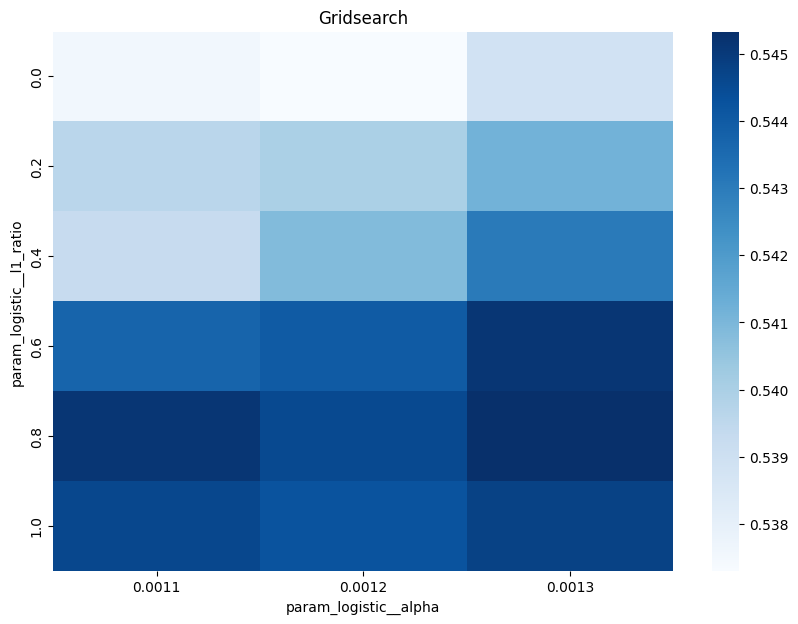

In [23]:
# Gridsearch table
plt.figure(figsize=(10,7))
plt.title('Gridsearch')
pvt_1_b=pd.pivot_table(pd.DataFrame(tuned_model_1_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_1_b=sns.heatmap(pvt_1_b, cmap="Blues")
plt.savefig('Gridsearch_model_1.png', dpi=600)

### Confusion Matrix

Accuracy: 0.6090322580645161
Precision: 0.6148648648648649
Recall: 0.9619450317124736


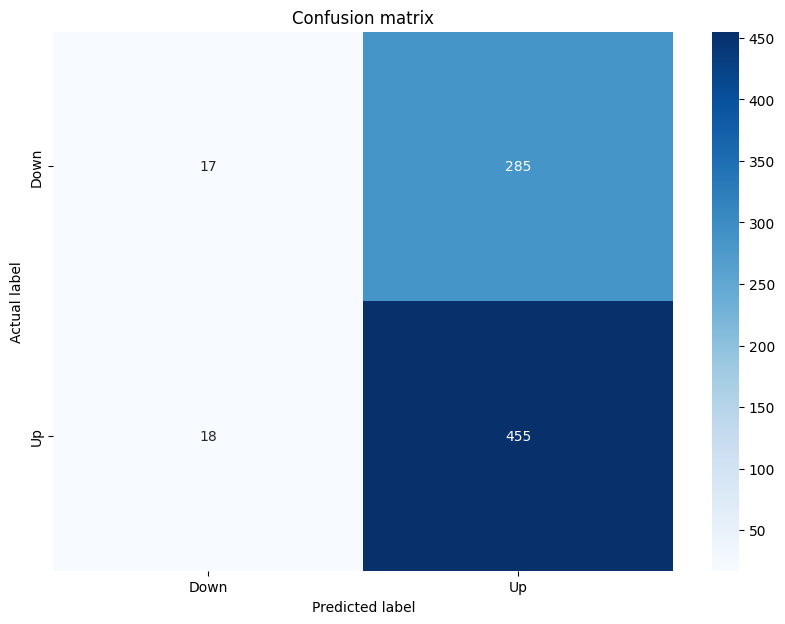

In [24]:
# Make predictions
y_pred_1_b=tuned_model_1_b.predict(X_test_1)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_1, y_pred_1_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_1_b.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_b))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_b))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_b))

### ROC Curve

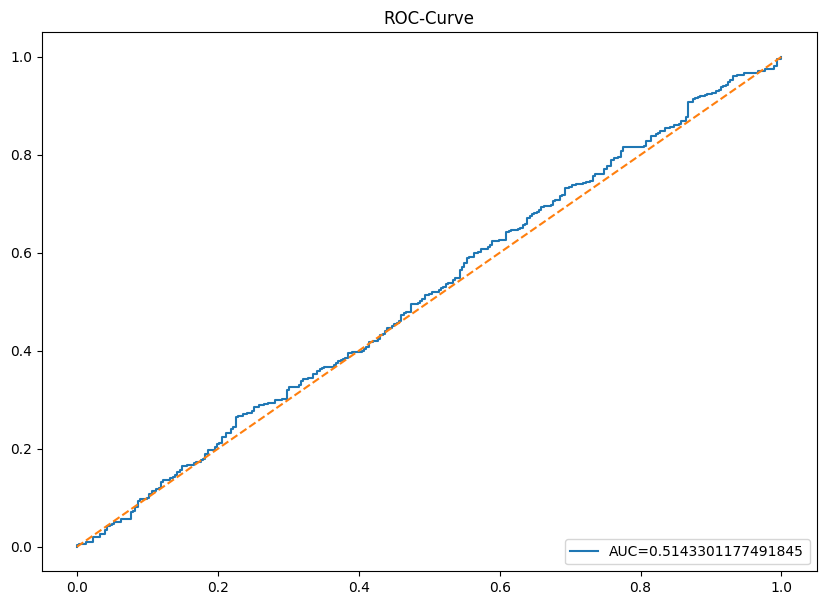

In [25]:
y_proba_1_b=tuned_model_1_b.predict_proba(X_test_1)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_1,  y_proba_1_b)
auc=metrics.roc_auc_score(y_test_1, y_proba_1_b)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_1_b.png', dpi=600)

#### 5.1.2 LSTM Model

In [26]:
class ModelStateReset(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()
reset=ModelStateReset()

In [27]:
# number of epochs
epochs=1
# number of units
LSTM_units_1_lstm=180
# numer of features
num_features_1_lstm=X_train_1.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.3
# print
verbose=0

#hyperparameter
batch_size=[1]

# hyperparameter
hyperparameter_1_lstm={'batch_size':batch_size}


# create Classifier
clf_1_lstm=KerasClassifier(build_fn=create_lstm,
                          epochs=epochs,
                          LSTM_units=LSTM_units_1_lstm,
                          num_samples=num_samples,
                          look_back=look_back,
                          num_features=num_features_1_lstm,
                          dropout_rate=dropout_rate,
                          recurrent_dropout=recurrent_dropout,
                          verbose=1)
# Gridsearch
search_1_lstm=GridSearchCV(estimator=clf_1_lstm,
                          param_grid=hyperparameter_1_lstm,
                          cv=tscv,
                          scoring=scoring_lstm, # accuracy
                          refit=True,
                          return_train_score=False)

# Fit model
tuned_model_1_lstm=search_1_lstm.fit(X_train_1_lstm, y_train_1, shuffle=False, callbacks=[reset])



print("\n")
print('Model 1:LSTM')

# View Accuracy
print(scoring_lstm +' of the best model: ', tuned_model_1_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_1_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_1_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_1_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_1_lstm.best_estimator_.get_params()['recurrent_dropout'])

781/781 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5374 - loss: 0.6910
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5453 - loss: 0.6913
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5523 - loss: 0.6887
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5679 - loss: 0.6867
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3877/3877 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5675 - loss: 0.6865
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.5712 - loss: 0.6833
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.5719 - loss: 0.6829
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6199/6199 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.5744 - loss: 0.6843
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accur

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6103225806451613
Precision: 0.6114732724902217
Recall: 0.9915433403805497


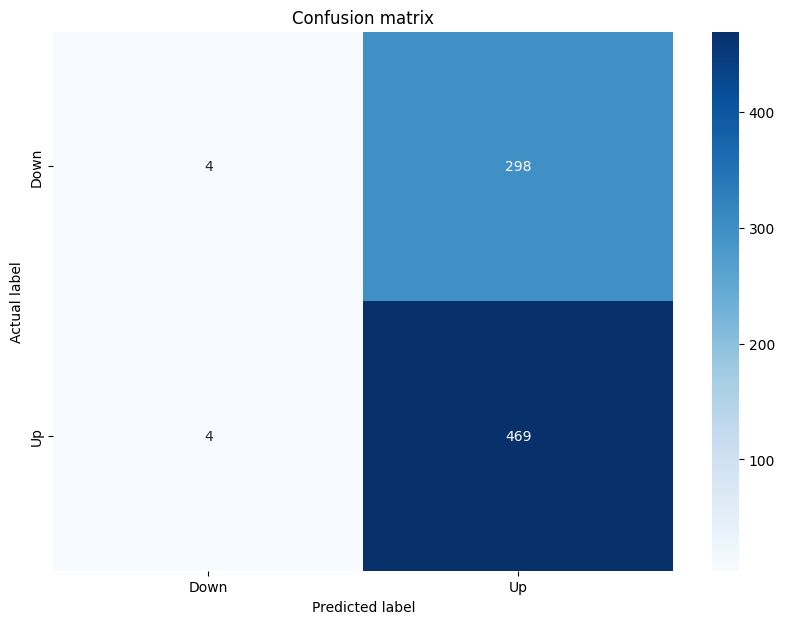

In [28]:
# Make predictions
y_pred_1_lstm=tuned_model_1_lstm.predict(X_test_1_lstm)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_1, y_pred_1_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_1_lstm.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_lstm))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_lstm))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_lstm))

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


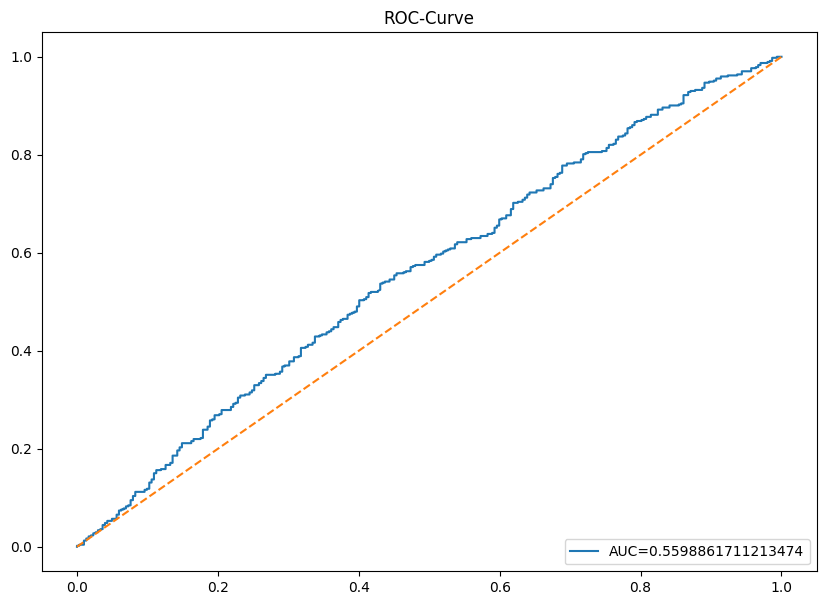

In [29]:
y_proba_1_lstm=tuned_model_1_lstm.predict_proba(X_test_1_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_1,  y_proba_1_lstm)
auc=metrics.roc_auc_score(y_test_1, y_proba_1_lstm)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_1_lstm.png', dpi=600)

### 5.2 Return+Volatility
#### 5.2.1 Baseline

In [30]:
# Model specific Parameter

# Number of iterations
iterations_2_b=[100]


# Grid Search

# Regularization
alpha_g_2_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_2_b=[0, 0.2, 0.4, 0.6, 0.8, 1]

# Create hyperparameter options
hyperparameters_g_2_b={'logistic__alpha':alpha_g_2_b,
                       'logistic__l1_ratio':l1_ratio_g_2_b,
                       'logistic__penalty':penalty_b,
                       'logistic__max_iter':iterations_2_b}

# Create grid search
search_g_2_b=GridSearchCV(estimator=pipeline_b,
                          param_grid=hyperparameters_g_2_b,
                          cv=tscv,
                          verbose=1,
                          n_jobs=-1,
                          scoring=scoring_b,
                          refit=metric_b,
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well

# Fit grid search
tuned_model_2_b=search_g_2_b.fit(X_train_2, y_train_2)


print("\n")
print('Model 2:Baseline')

# View Cost function
print('Loss function:', tuned_model_2_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy
print(metric_b +' of the best model: ', tuned_model_2_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_2_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_2_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_2_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_2_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_2_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_2_b.best_estimator_.steps[1][1].coef_[0][:]))


Fitting 8 folds for each of 54 candidates, totalling 432 fits


Model 2:Baseline
Loss function: log_loss
accuracy of the best model:  0.5358527131782945


Best hyperparameters:
Number of iterations: 100
Penalty: l1
Alpha: 0.0012
l1_ratio: 0
Total number of features: 49
Number of selected features: 3


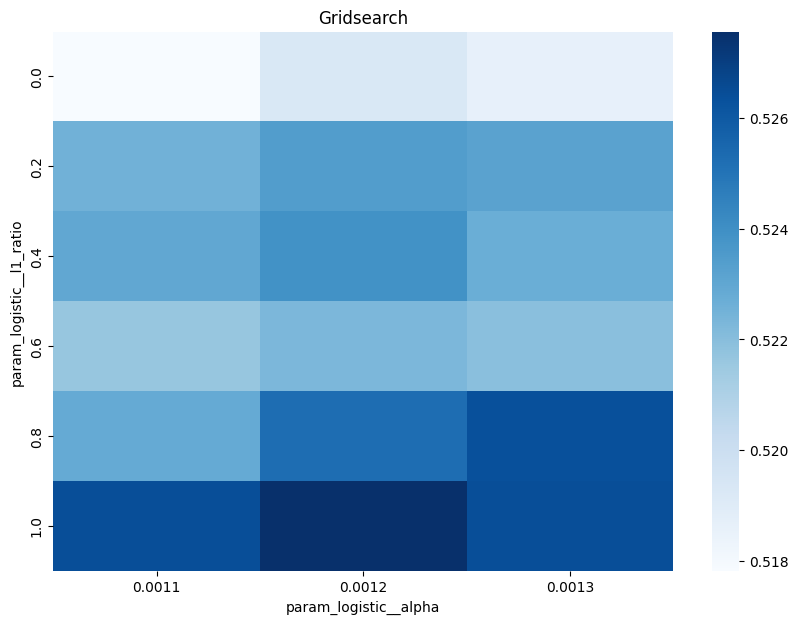

In [31]:
# Gridsearch table
plt.figure(figsize=(10,7))
plt.title('Gridsearch')
pvt_2_b=pd.pivot_table(pd.DataFrame(tuned_model_2_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_2_b=sns.heatmap(pvt_2_b, cmap="Blues")
plt.savefig('Gridsearch_model_2.png', dpi=600)

Accuracy: 0.5793548387096774
Precision: 0.6329113924050633
Recall: 0.7399577167019028


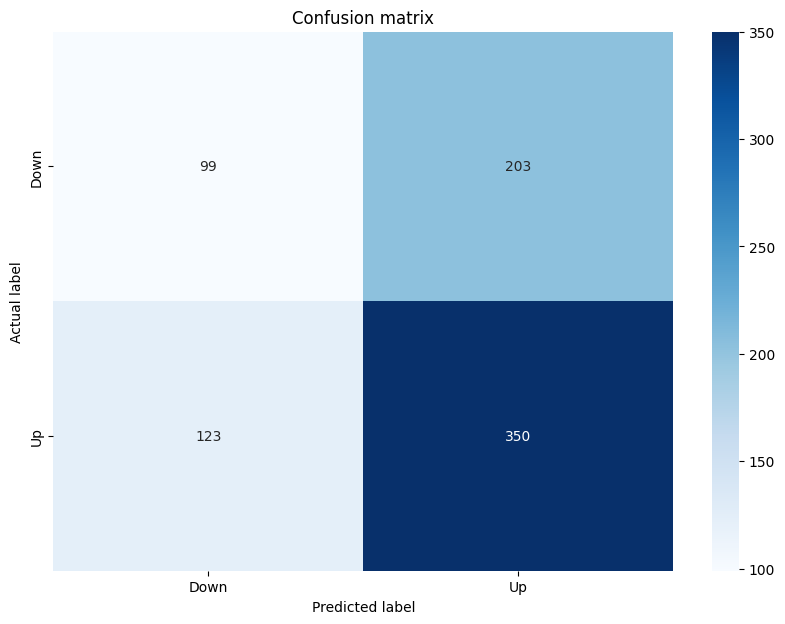

In [32]:
# Make predictions
y_pred_2_b=tuned_model_2_b.predict(X_test_2)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_2, y_pred_2_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_2_b.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_2, y_pred_2_b))
print("Precision:",metrics.precision_score(y_test_2, y_pred_2_b))
print("Recall:",metrics.recall_score(y_test_2, y_pred_2_b))


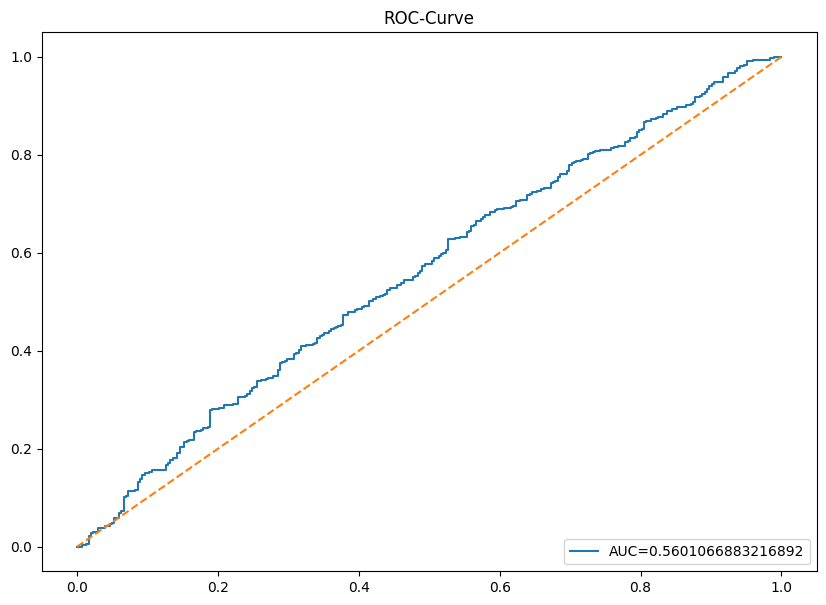

In [33]:
y_proba_2_b=tuned_model_2_b.predict_proba(X_test_2)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_2,  y_proba_2_b)
auc=metrics.roc_auc_score(y_test_2, y_proba_2_b)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_2_b.png', dpi=600)

In [34]:
# number of epochs
epochs=1
# number of units
LSTM_units_2_lstm=180
# number of samples
num_samples=1
# time_steps
look_back=1
# numer of features
num_features_2_lstm=X_train_2.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.25
# print
verbose=0

#hyperparameter
batch_size=[1]

# hyperparameter
hyperparameter_2_lstm={'batch_size':batch_size}


# create Classifier
clf_2_lstm=KerasClassifier(build_fn=create_lstm,
                           epochs=epochs,
                           LSTM_units=LSTM_units_2_lstm,
                           num_samples=num_samples,
                           look_back=look_back,
                           num_features=num_features_2_lstm,
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=1)
# Gridsearch
search_2_lstm=GridSearchCV(estimator=clf_2_lstm,
                           param_grid=hyperparameter_2_lstm,
                           cv=tscv,
                           scoring=scoring_lstm, # accuracy
                           refit=True,
                           return_train_score=False)

# Fit model
tuned_model_2_lstm=search_2_lstm.fit(X_train_2_lstm, y_train_2, shuffle=False, callbacks=[reset])



print("\n")
print('Model 2:LSTM')
# View Accuracy
print(scoring_lstm +' of the best model: ', tuned_model_2_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_2_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_2_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_2_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_2_lstm.best_estimator_.get_params()['recurrent_dropout'])

781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5511 - loss: 0.6867
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5248 - loss: 0.6907
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5517 - loss: 0.6840
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5612 - loss: 0.6827
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3877/3877 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.5663 - loss: 0.6807
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.5713 - loss: 0.6817
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.5695 - loss: 0.6807
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6199/6199 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.5702 - loss: 0.6801
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accur

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6103225806451613
Precision: 0.6103225806451613
Recall: 1.0


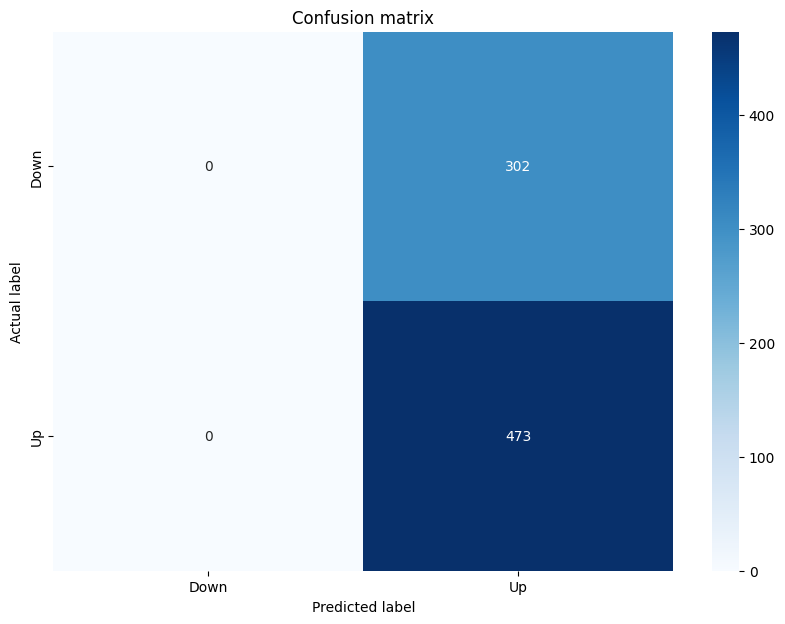

In [35]:
# Make predictions
y_pred_2_lstm=tuned_model_2_lstm.predict(X_test_2_lstm)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_2, y_pred_2_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_2_lstm.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_2, y_pred_2_lstm))
print("Precision:",metrics.precision_score(y_test_2, y_pred_2_lstm))
print("Recall:",metrics.recall_score(y_test_2, y_pred_2_lstm))

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


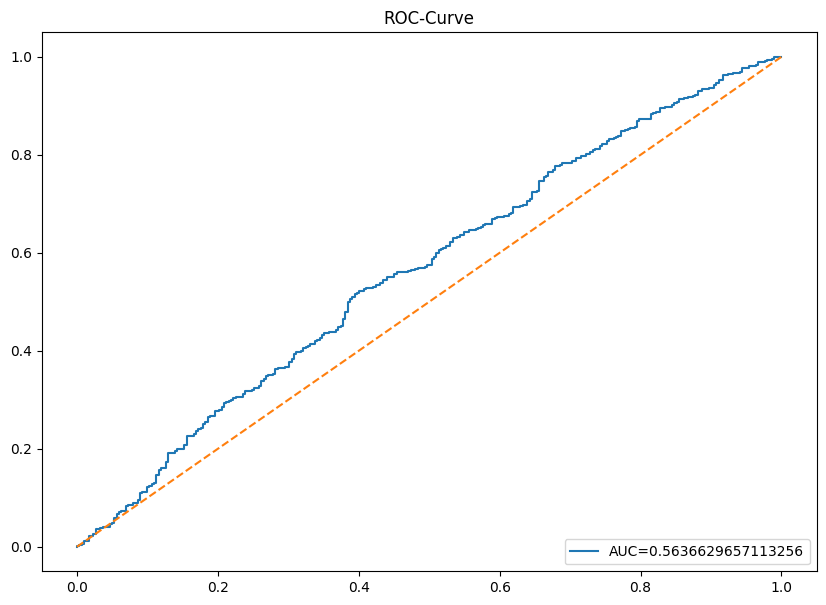

In [36]:
y_proba_2_lstm=tuned_model_2_lstm.predict_proba(X_test_2_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_2,  y_proba_2_lstm)
auc=metrics.roc_auc_score(y_test_2, y_proba_2_lstm)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_2_lstm.png', dpi=600)

### 5.3 Return + Liquidity return + Volatility
#### 5.3.1 Baseline

In [37]:
# Model specific Parameter

# Number of iterations
iterations_3_b=[100]


# Grid Search

# Regularization
alpha_g_3_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_3_b=[0, 0.2, 0.4, 0.6, 0.8, 1]

# Create hyperparameter options
hyperparameters_g_3_b={'logistic__alpha':alpha_g_3_b,
                       'logistic__l1_ratio':l1_ratio_g_3_b,
                       'logistic__penalty':penalty_b,
                       'logistic__max_iter':iterations_3_b}

# Create grid search
search_g_3_b=GridSearchCV(estimator=pipeline_b,
                          param_grid=hyperparameters_g_3_b,
                          cv=tscv,
                          verbose=0,
                          n_jobs=-1,
                          scoring=scoring_b,
                          refit=metric_b,
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well

# Fit grid search
tuned_model_3_b=search_g_3_b.fit(X_train_3, y_train_3)

print("\n")
print('Model 3:Baseline')

# View Cost function
print('Loss function:', tuned_model_3_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy
print(metric_b +' of the best model: ', tuned_model_3_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_3_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_3_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_3_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_3_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_3_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_3_b.best_estimator_.steps[1][1].coef_[0][:]))



Model 3:Baseline
Loss function: log_loss
accuracy of the best model:  0.5373062015503876


Best hyperparameters:
Number of iterations: 100
Penalty: l1
Alpha: 0.0013
l1_ratio: 0
Total number of features: 74
Number of selected features: 8


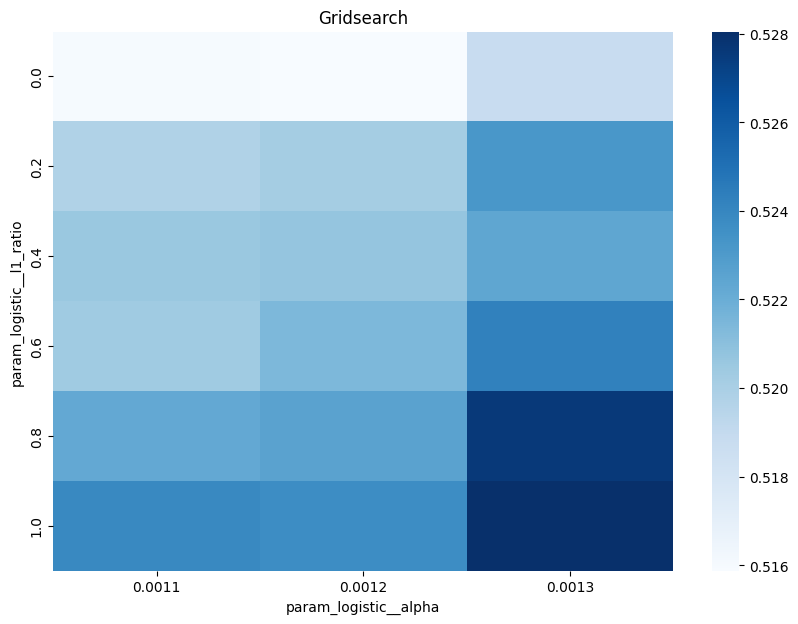

In [38]:
# Gridsearch table
plt.figure(figsize=(10,7))
plt.title('Gridsearch')
pvt_3_b=pd.pivot_table(pd.DataFrame(tuned_model_3_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_3_b=sns.heatmap(pvt_3_b, cmap="Blues")
plt.savefig('Gridsearch_model_3.png', dpi=600)

Accuracy: 0.5780645161290323
Precision: 0.6502057613168725
Recall: 0.6680761099365751


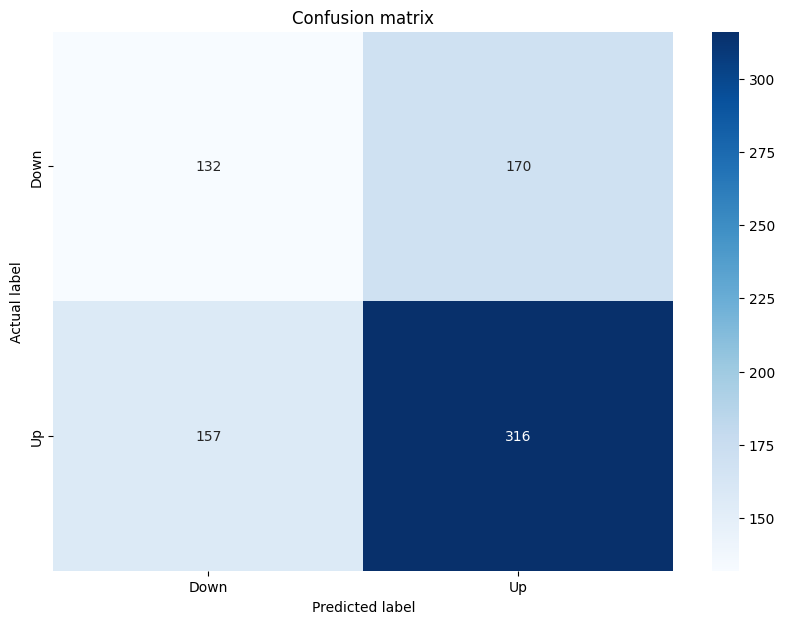

In [39]:
# Make predictions
y_pred_3_b=tuned_model_3_b.predict(X_test_3)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_3, y_pred_3_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_3_b.png', dpi=600)
print("Accuracy:",metrics.accuracy_score(y_test_3, y_pred_3_b))
print("Precision:",metrics.precision_score(y_test_3, y_pred_3_b))
print("Recall:",metrics.recall_score(y_test_3, y_pred_3_b))

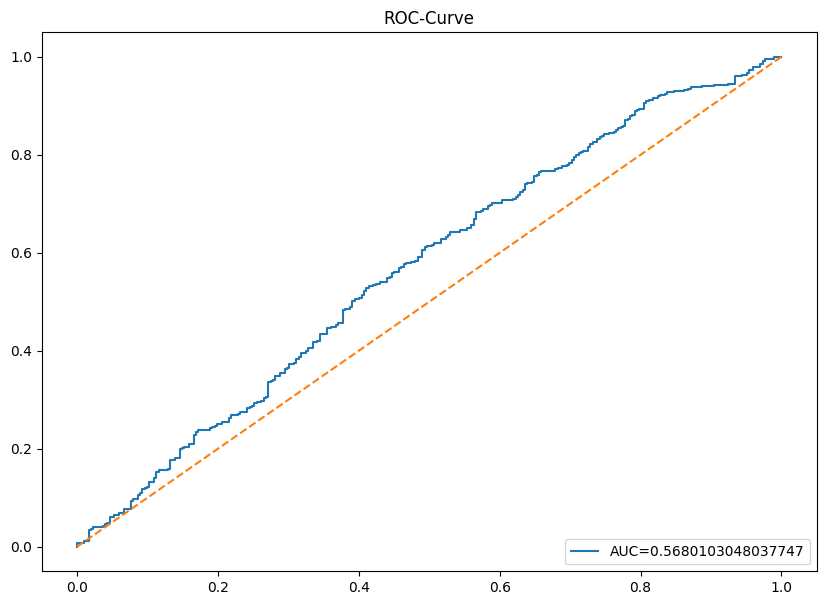

In [40]:
y_proba_3_b=tuned_model_3_b.predict_proba(X_test_3)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_3,  y_proba_3_b)
auc=metrics.roc_auc_score(y_test_3, y_proba_3_b)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_3_b.png', dpi=600)

#### 5.3.2 LSTM

In [41]:
# number of epochs
epochs=1
# number of units
LSTM_units_3_lstm=180
# number of samples
num_samples=1
# time_steps
look_back=1
# numer of features
num_features_3_lstm=X_train_3.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.2
# print
verbose=0

#hyperparameter
batch_size=[1]

# hyperparameter
hyperparameter_3_lstm={'batch_size':batch_size}


# create Classifier
clf_3_lstm=KerasClassifier(build_fn=create_lstm,
                           epochs=epochs,
                           LSTM_units=LSTM_units_3_lstm,
                           num_samples=num_samples,
                           look_back=look_back,
                           num_features=num_features_3_lstm,
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=1)
# Gridsearch
search_3_lstm=GridSearchCV(estimator=clf_3_lstm,
                           param_grid=hyperparameter_3_lstm,
                           cv=tscv,
                           scoring=scoring_lstm, # accuracy
                           refit=True,
                           return_train_score=False)

# Fit model
tuned_model_3_lstm=search_3_lstm.fit(X_train_3_lstm, y_train_3, shuffle=False, callbacks=[reset])



print("\n")
print('Model 3:LSTM')

# View Accuracy
print(scoring_lstm +' of the best model: ', tuned_model_3_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_3_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_3_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_3_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_3_lstm.best_estimator_.get_params()['recurrent_dropout'])

781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5248 - loss: 0.6862
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5336 - loss: 0.6874
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5540 - loss: 0.6845
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.5656 - loss: 0.6827
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3877/3877 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.5715 - loss: 0.6803
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.5727 - loss: 0.6800
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.5781 - loss: 0.6784
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6199/6199 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.5732 - loss: 0.6785
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accur

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6103225806451613
Precision: 0.6103225806451613
Recall: 1.0


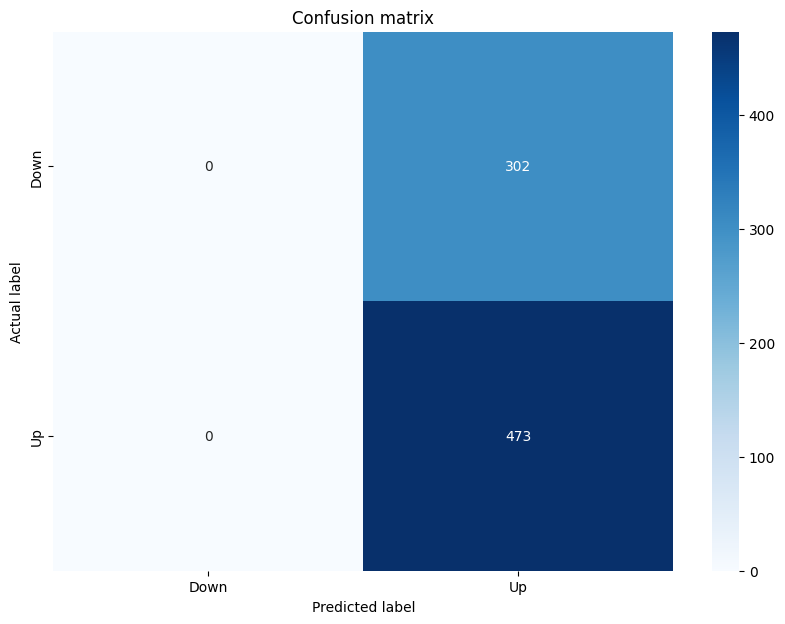

In [42]:
# Make predictions
y_pred_3_lstm=tuned_model_3_lstm.predict(X_test_3_lstm)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_3, y_pred_3_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_3_lstm.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_3, y_pred_3_lstm))
print("Precision:",metrics.precision_score(y_test_3, y_pred_3_lstm))
print("Recall:",metrics.recall_score(y_test_3, y_pred_3_lstm))

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


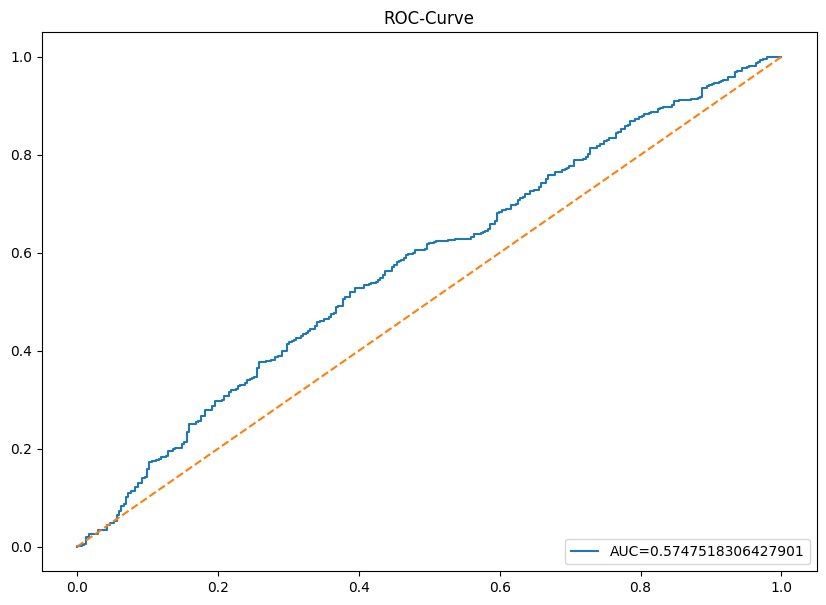

In [43]:
y_proba_3_lstm=tuned_model_3_lstm.predict_proba(X_test_3_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_3,  y_proba_3_lstm)
auc=metrics.roc_auc_score(y_test_3, y_proba_3_lstm)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_3_lstm.png', dpi=600)

### 5.4 Return + Liquidity + Amount
#### 5.4.1 Baseline

In [44]:
# Model specific Parameter

# Number of iterations
iterations_4_b=[100]


# Grid Search

# Regularization
alpha_g_4_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_4_b=[0, 0.2, 0.4, 0.6, 0.8, 1]

# Create hyperparameter options
hyperparameters_g_4_b={'logistic__alpha':alpha_g_4_b,
                       'logistic__l1_ratio':l1_ratio_g_4_b,
                       'logistic__penalty':penalty_b,
                       'logistic__max_iter':iterations_4_b}

# Create grid search
search_g_4_b=GridSearchCV(estimator=pipeline_b,
                          param_grid=hyperparameters_g_4_b,
                          cv=tscv,
                          verbose=0,
                          n_jobs=-1,
                          scoring=scoring_b,
                          refit=metric_b,
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well

# Fit grid search
tuned_model_4_b=search_g_4_b.fit(X_train_4, y_train_4)
#search_g_6_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_6_b=uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_6_b=uniform(loc=0, scale=1)

# Create hyperparameter options
#hyperparameters_r_6_b={'logistic__alpha':alpha_r_6_b, 'logistic__l1_ratio':l1_ratio_r_6_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_6_b}

# Create randomized search
#search_r_6_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_6_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_6_b=search_r_4_b.fit(X_train_6, y_train_6)


print("\n")
print('Model 4:Baseline')

# View Cost function
print('Loss function:', tuned_model_4_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy
print(metric_b +' of the best model: ', tuned_model_4_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_4_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_4_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_4_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_4_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_4_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_4_b.best_estimator_.steps[1][1].coef_[0][:]))



/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/sk



Model 4:Baseline
Loss function: log_loss
accuracy of the best model:  0.536498708010336


Best hyperparameters:
Number of iterations: 100
Penalty: l1
Alpha: 0.0013
l1_ratio: 0
Total number of features: 98
Number of selected features: 12


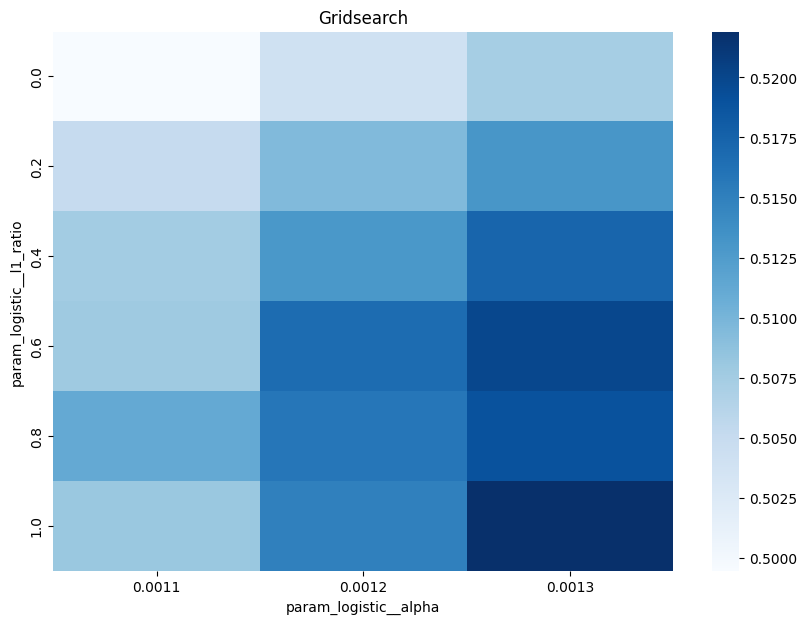

In [45]:
# Gridsearch table
plt.figure(figsize=(10,7))
plt.title('Gridsearch')
pvt_4_b=pd.pivot_table(pd.DataFrame(tuned_model_4_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_4_b=sns.heatmap(pvt_4_b, cmap="Blues")
plt.savefig('Gridsearch_model_4.png', dpi=600)

Accuracy: 0.5509677419354839
Precision: 0.6666666666666666
Recall: 0.5285412262156448


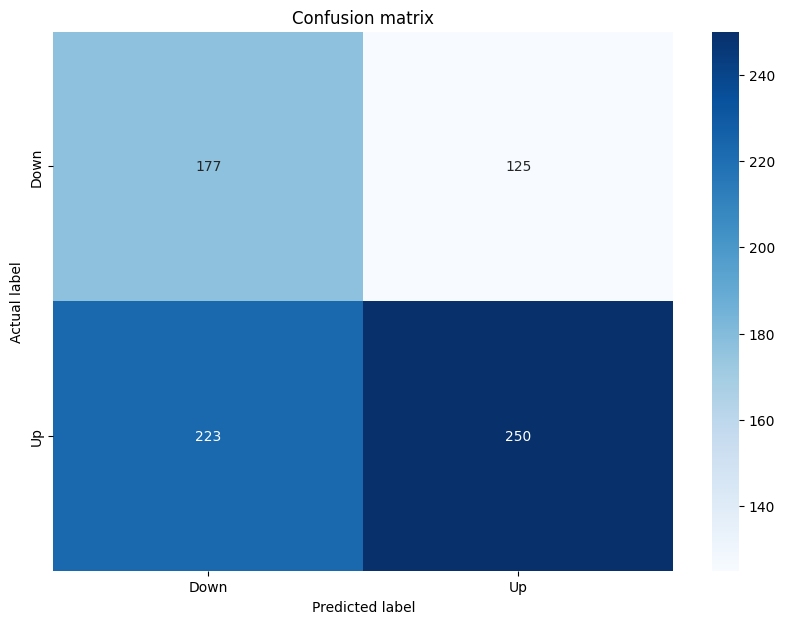

In [46]:
# Make predictions
y_pred_4_b=tuned_model_4_b.predict(X_test_4)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_4, y_pred_4_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_4_b.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_4, y_pred_4_b))
print("Precision:",metrics.precision_score(y_test_4, y_pred_4_b))
print("Recall:",metrics.recall_score(y_test_4, y_pred_4_b))

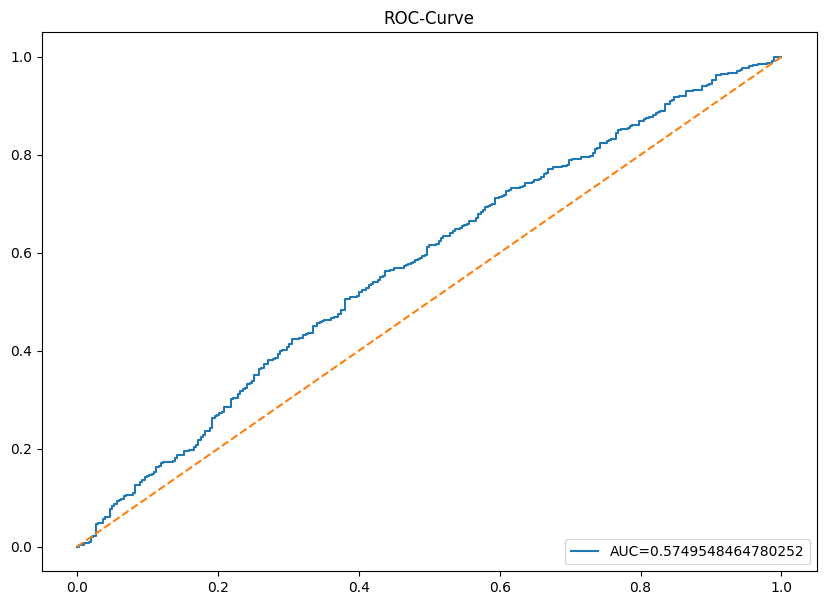

In [47]:
y_proba_4_b=tuned_model_4_b.predict_proba(X_test_4)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_4,  y_proba_4_b)
auc=metrics.roc_auc_score(y_test_4, y_proba_4_b)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_4_b.png', dpi=600)

#### 5.4.2 LSTM

In [48]:
# number of epochs
epochs=1
# number of units
LSTM_units_4_lstm=200
# number of samples
num_samples=1
# time_steps
look_back=1
# numer of features
num_features_4_lstm=X_train_4.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.2
# print
verbose=0

#hyperparameter
batch_size=[1]

# hyperparameter
hyperparameter_4_lstm={'batch_size':batch_size}


# create Classifier
clf_4_lstm=KerasClassifier(build_fn=create_lstm,
                           epochs=epochs,
                           LSTM_units=LSTM_units_4_lstm,
                           num_samples=num_samples,
                           look_back=look_back,
                           num_features=num_features_4_lstm,
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=1)
# Gridsearch
search_4_lstm=GridSearchCV(estimator=clf_4_lstm,
                           param_grid=hyperparameter_4_lstm,
                           cv=tscv,
                           scoring=scoring_lstm, # accuracy
                           refit=True,
                           return_train_score=False)

# Fit model
tuned_model_4_lstm=search_4_lstm.fit(X_train_4_lstm, y_train_4, shuffle=False, callbacks=[reset])


print("\n")
print('Model 4:LSTM')

# View Accuracy
print(scoring_lstm +' of the best model: ', tuned_model_4_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_4_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_4_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_4_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_4_lstm.best_estimator_.get_params()['recurrent_dropout'])

781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5606 - loss: 0.6841
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5583 - loss: 0.6844
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5826 - loss: 0.6809
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.5885 - loss: 0.6842
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3877/3877 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5874 - loss: 0.6783
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.5876 - loss: 0.6791
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.5811 - loss: 0.6797
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6199/6199 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.5767 - loss: 0.6791
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accur

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6103225806451613
Precision: 0.6103225806451613
Recall: 1.0


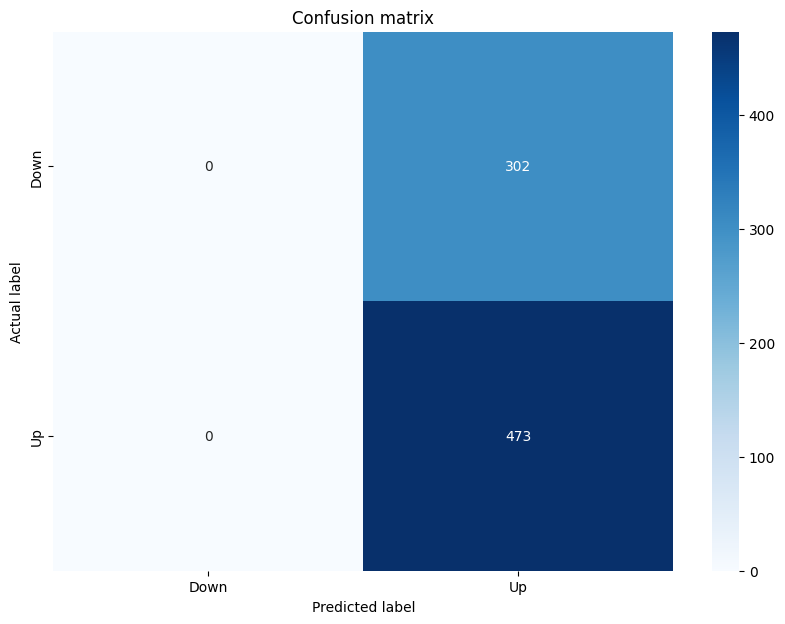

In [49]:
# Make predictions
y_pred_4_lstm=tuned_model_4_lstm.predict(X_test_4_lstm)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_4, y_pred_4_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_4_lstm.png', dpi=600)
print("Accuracy:",metrics.accuracy_score(y_test_4, y_pred_4_lstm))
print("Precision:",metrics.precision_score(y_test_4, y_pred_4_lstm))
print("Recall:",metrics.recall_score(y_test_4, y_pred_4_lstm))

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


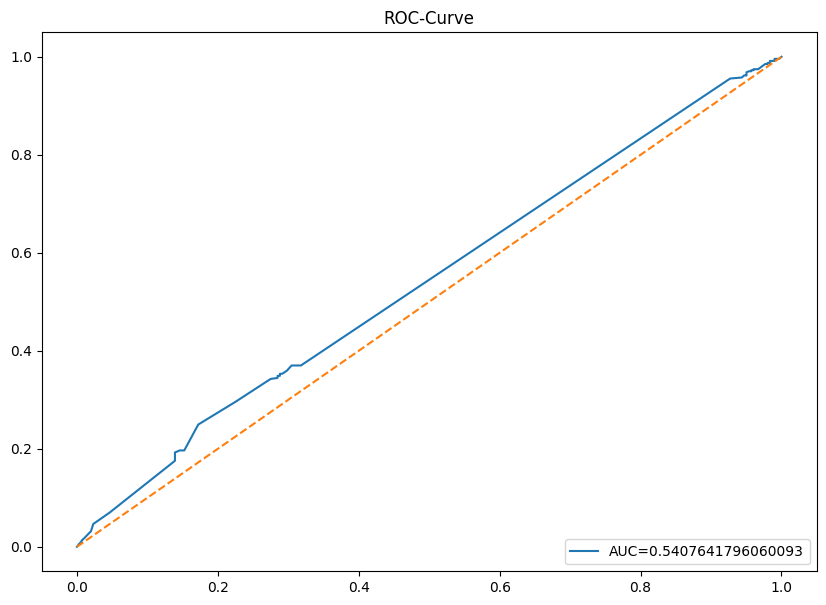

In [50]:
y_proba_4_lstm=tuned_model_4_lstm.predict_proba(X_test_4_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_4,  y_proba_4_lstm)
auc=metrics.roc_auc_score(y_test_4, y_proba_4_lstm)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_4_lstm.png', dpi=600)

### 5.5 Return + Liquidity return + AMOUNT + Volatility
#### 5.5.1 Baseline

In [51]:
# Model specific Parameter

# Number of iterations
iterations_5_b=[100]


# Grid Search

# Regularization
alpha_g_5_b=[0.0019, 0.002, 0.0021]
l1_ratio_g_5_b=[0, 0.2, 0.4, 0.6, 0.8, 1]

# Create hyperparameter options
hyperparameters_g_5_b={'logistic__alpha':alpha_g_5_b,
                       'logistic__l1_ratio':l1_ratio_g_5_b,
                       'logistic__penalty':penalty_b,
                       'logistic__max_iter':iterations_5_b}

# Create grid search
search_g_5_b=GridSearchCV(estimator=pipeline_b,
                          param_grid=hyperparameters_g_5_b,
                          cv=tscv,
                          verbose=0,
                          n_jobs=-1,
                          scoring=scoring_b,
                          refit=metric_b,
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well

# Fit grid search
tuned_model_5_b=search_g_5_b.fit(X_train_5, y_train_5)
#search_g_7_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_7_b=uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_7_b=uniform(loc=0, scale=1)

# Create hyperparameter options
#hyperparameters_r_7_b={'logistic__alpha':alpha_r_7_b, 'logistic__l1_ratio':l1_ratio_r_7_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_7_b}

# Create randomized search
#search_r_7_b=RandomizedSearchCV(pipeline_b, hyperparameters_r_7_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_7_b=search_r_4_b.fit(X_train_7, y_train_7)


print("\n")
print('Model 5:Baseline')

# View Cost function
print('Loss function:', tuned_model_5_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy
print(metric_b +' of the best model: ', tuned_model_5_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_5_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_5_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_5_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_5_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_5_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_5_b.best_estimator_.steps[1][1].coef_[0][:]))





Model 5:Baseline
Loss function: log_loss
accuracy of the best model:  0.5397286821705426


Best hyperparameters:
Number of iterations: 100
Penalty: l1
Alpha: 0.002
l1_ratio: 0
Total number of features: 122
Number of selected features: 7


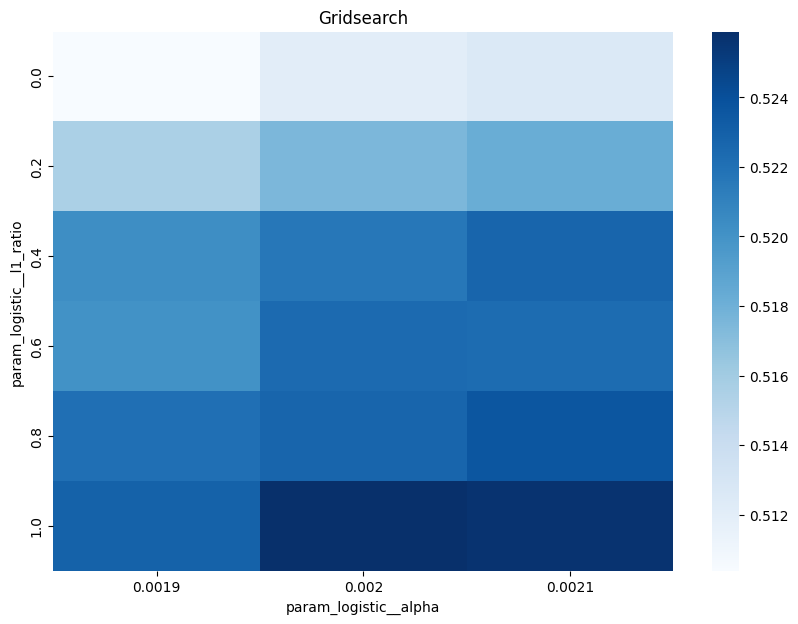

In [52]:
# Gridsearch table
plt.figure(figsize=(10,7))
plt.title('Gridsearch')
pvt_5_b=pd.pivot_table(pd.DataFrame(tuned_model_5_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_5_b=sns.heatmap(pvt_5_b, cmap="Blues")
plt.savefig('Gridsearch_model_5.png', dpi=600)

Accuracy: 0.6
Precision: 0.6473779385171791
Recall: 0.7568710359408034


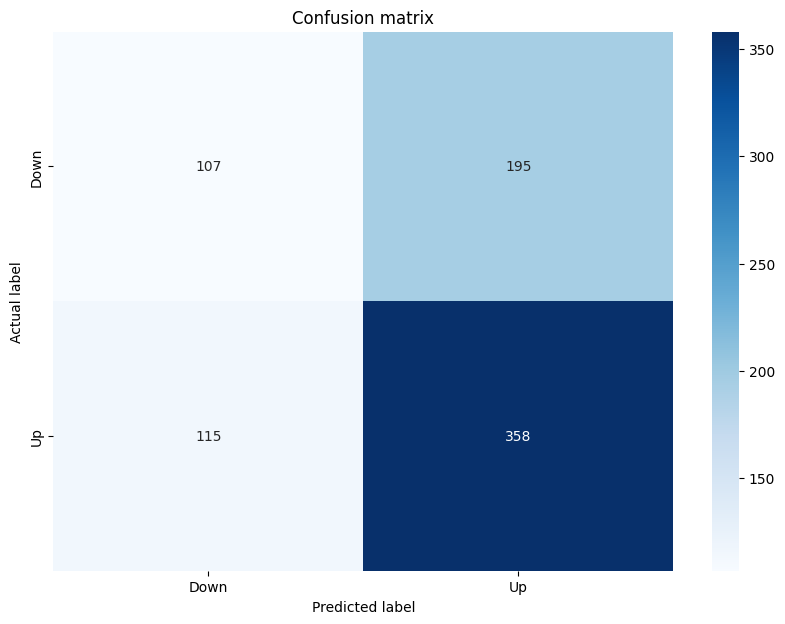

In [53]:
# Make predictions
y_pred_5_b=tuned_model_5_b.predict(X_test_5)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_5, y_pred_5_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_5_b.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_5, y_pred_5_b))
print("Precision:",metrics.precision_score(y_test_5, y_pred_5_b))
print("Recall:",metrics.recall_score(y_test_5, y_pred_5_b))

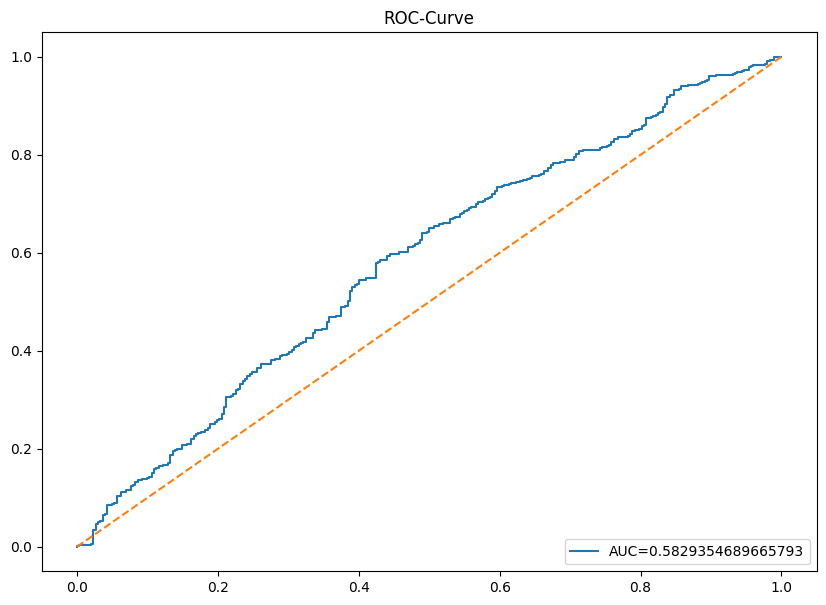

In [54]:
y_proba_5_b=tuned_model_5_b.predict_proba(X_test_5)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_5,  y_proba_5_b)
auc=metrics.roc_auc_score(y_test_5, y_proba_5_b)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_5_b.png', dpi=600)

#### 5.5.2 LSTM

In [55]:
# number of epochs
epochs=1
# number of units
LSTM_units_5_lstm=200
# numer of features
num_features_5_lstm=X_train_5.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.2
# print
verbose=0

#hyperparameter
batch_size=[1]

# hyperparameter
hyperparameter_5_lstm={'batch_size':batch_size}


# create Classifier
clf_5_lstm=KerasClassifier(build_fn=create_lstm,
                           epochs=epochs,
                           LSTM_units=LSTM_units_5_lstm,
                           num_samples=num_samples,
                           look_back=look_back,
                           num_features=num_features_5_lstm,
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=1)
# Gridsearch
search_5_lstm=GridSearchCV(estimator=clf_5_lstm,
                           param_grid=hyperparameter_5_lstm,
                           cv=tscv,
                           scoring=scoring_lstm, # accuracy
                           refit=True,
                           return_train_score=False)

# Fit model
tuned_model_5_lstm=search_5_lstm.fit(X_train_5_lstm, y_train_5, shuffle=False, callbacks=[reset])


print("\n")
print('Model 5:LSTM')

# View Accuracy
print(scoring_lstm +' of the best model: ', tuned_model_5_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_5_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_5_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_5_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_5_lstm.best_estimator_.get_params()['recurrent_dropout'])

781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5510 - loss: 0.6872
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5658 - loss: 0.6832
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5684 - loss: 0.6839
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.5825 - loss: 0.6836
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3877/3877 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5768 - loss: 0.6774
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.5888 - loss: 0.6800
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.5855 - loss: 0.6774
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6199/6199 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.5786 - loss: 0.6766
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accur

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6103225806451613
Precision: 0.6103225806451613
Recall: 1.0


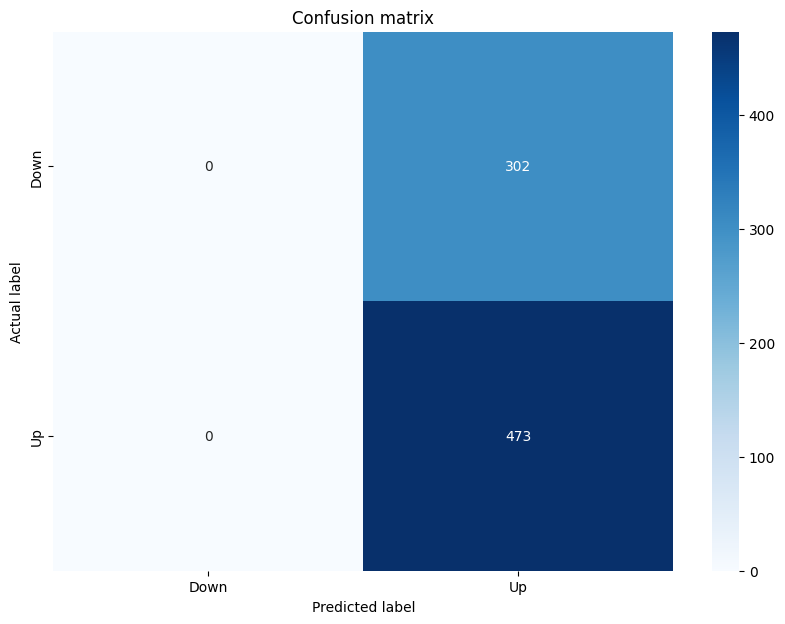

In [56]:
# Make predictions
y_pred_5_lstm=tuned_model_5_lstm.predict(X_test_5_lstm)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_5, y_pred_5_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_5_lstm.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_5, y_pred_5_lstm))
print("Precision:",metrics.precision_score(y_test_5, y_pred_5_lstm))
print("Recall:",metrics.recall_score(y_test_5, y_pred_5_lstm))

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


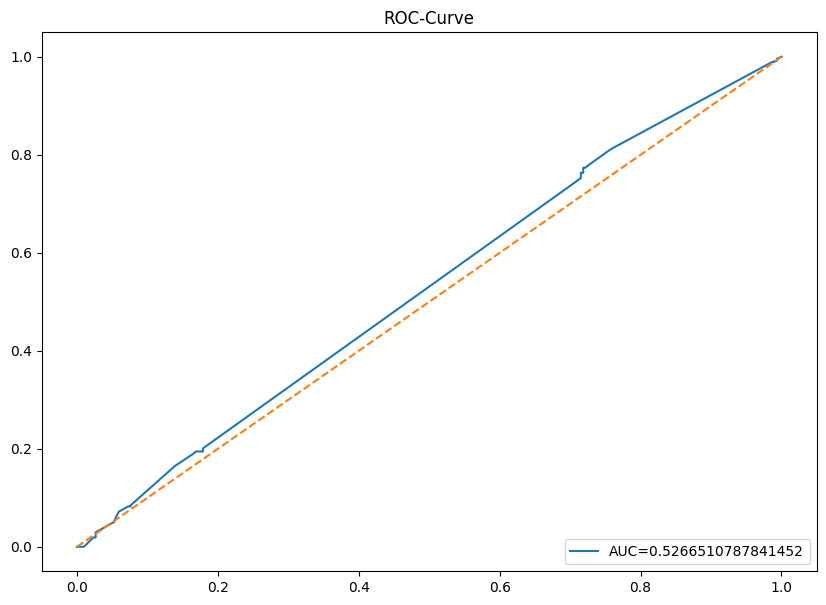

In [57]:
y_proba_5_lstm=tuned_model_5_lstm.predict_proba(X_test_5_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_5,  y_proba_5_lstm)
auc=metrics.roc_auc_score(y_test_5, y_proba_5_lstm)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_5_lstm.png', dpi=600)

### 5.6 Return + Liquidity return
#### 5.6.1 Baseline

In [60]:
# Model specific Parameter

# Number of iterations
iterations_6_b=[100]


# Grid Search

# Regularization
alpha_g_6_b=[0.0011, 0.0012, 0.0013]
l1_ratio_g_6_b=[0, 0.2, 0.4, 0.6, 0.8, 1]

# Create hyperparameter options
hyperparameters_g_6_b={'logistic__alpha':alpha_g_6_b,
                       'logistic__l1_ratio':l1_ratio_g_6_b,
                       'logistic__penalty':penalty_b,
                       'logistic__max_iter':iterations_6_b}

# Create grid search
search_g_6_b=GridSearchCV(estimator=pipeline_b,
                          param_grid=hyperparameters_g_6_b,
                          cv=tscv,
                          verbose=0,
                          n_jobs=-1,
                          scoring=scoring_b,
                          refit=metric_b,
                          return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well

# Fit grid search
tuned_model_6_b=search_g_6_b.fit(X_train_6, y_train_6)

print("\n")
print('Model 6:Baseline')

# View Cost function
print('Loss function:', tuned_model_6_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy
print(metric_b +' of the best model: ', tuned_model_6_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_6_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_6_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_6_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_6_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_6_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_6_b.best_estimator_.steps[1][1].coef_[0][:]))



Model 6:Baseline
Loss function: log_loss
accuracy of the best model:  0.5505490956072352


Best hyperparameters:
Number of iterations: 100
Penalty: l1
Alpha: 0.0013
l1_ratio: 0
Total number of features: 50
Number of selected features: 7


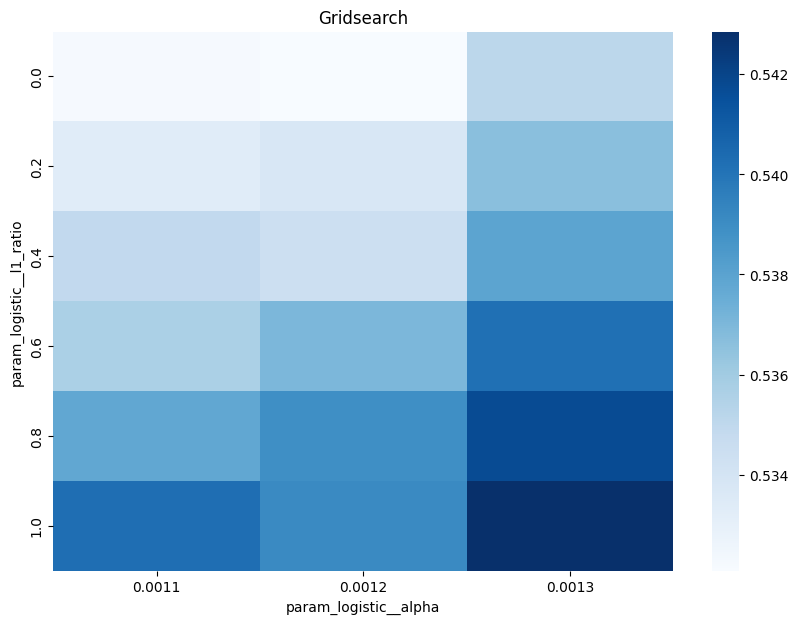

In [61]:
# Gridsearch table
plt.figure(figsize=(10,7))
plt.title('Gridsearch')
pvt_6_b=pd.pivot_table(pd.DataFrame(tuned_model_6_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_6_b=sns.heatmap(pvt_6_b, cmap="Blues")
plt.savefig('Gridsearch_model_6.png', dpi=600)

Accuracy: 0.607741935483871
Precision: 0.6188466947960619
Recall: 0.9302325581395349


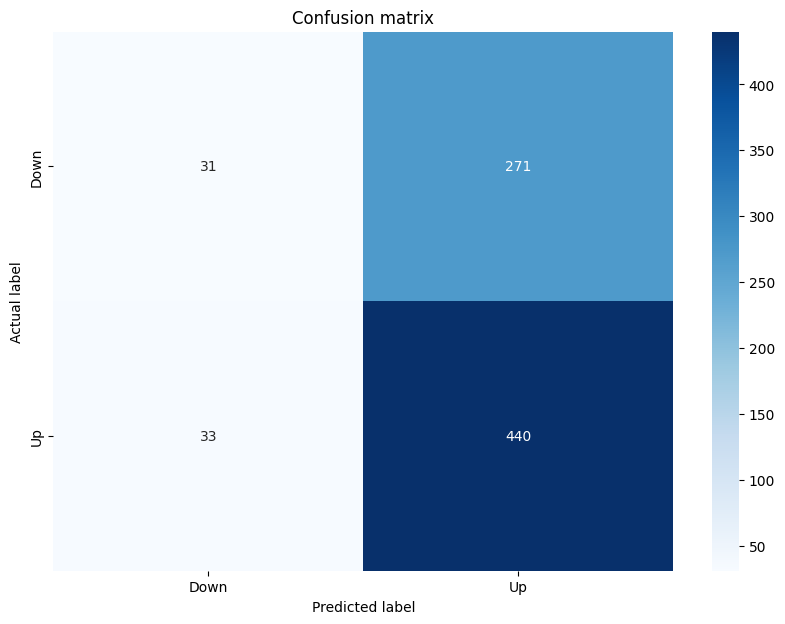

In [62]:
# Make predictions
y_pred_6_b=tuned_model_6_b.predict(X_test_6)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_6, y_pred_6_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_6_b.png', dpi=600)
print("Accuracy:",metrics.accuracy_score(y_test_6, y_pred_6_b))
print("Precision:",metrics.precision_score(y_test_6, y_pred_6_b))
print("Recall:",metrics.recall_score(y_test_6, y_pred_6_b))

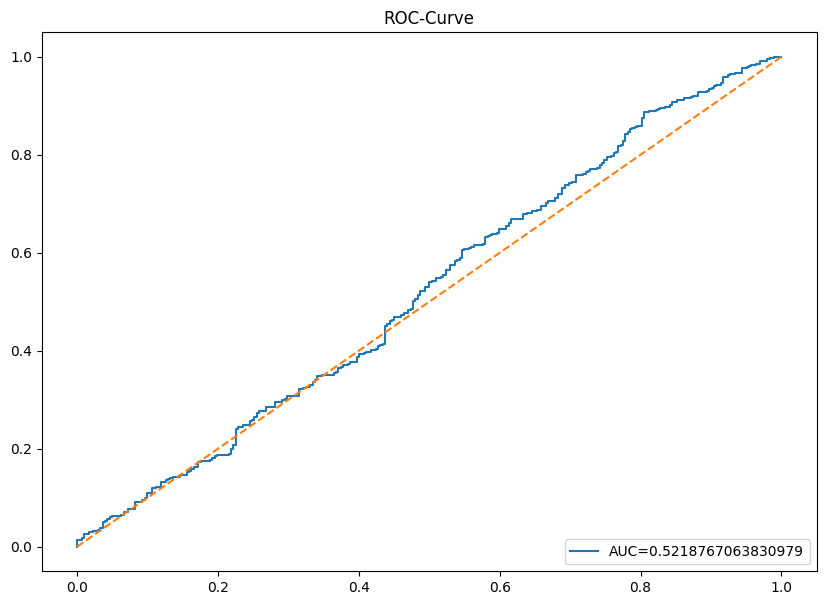

In [63]:
y_proba_6_b=tuned_model_6_b.predict_proba(X_test_6)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_6,  y_proba_6_b)
auc=metrics.roc_auc_score(y_test_6, y_proba_6_b)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_6_b.png', dpi=600)

#### 5.6.2 LSTM

In [64]:
# number of epochs
epochs=1
# number of units
LSTM_units_6_lstm=180
# number of samples
num_samples=1
# time_steps
look_back=1
# numer of features
num_features_6_lstm=X_train_6.shape[1]
# Regularization
dropout_rate=0.
recurrent_dropout=0.2
# print
verbose=0

#hyperparameter
batch_size=[1]

# hyperparameter
hyperparameter_6_lstm={'batch_size':batch_size}


# create Classifier
clf_6_lstm=KerasClassifier(build_fn=create_lstm,
                           epochs=epochs,
                           LSTM_units=LSTM_units_6_lstm,
                           num_samples=num_samples,
                           look_back=look_back,
                           num_features=num_features_6_lstm,
                           dropout_rate=dropout_rate,
                           recurrent_dropout=recurrent_dropout,
                           verbose=1)
# Gridsearch
search_6_lstm=GridSearchCV(estimator=clf_6_lstm,
                           param_grid=hyperparameter_6_lstm,
                           cv=tscv,
                           scoring=scoring_lstm, # accuracy
                           refit=True,
                           return_train_score=False)

# Fit model
tuned_model_6_lstm=search_6_lstm.fit(X_train_6_lstm, y_train_6, shuffle=False, callbacks=[reset])



print("\n")
print('Model 6:LSTM')

# View Accuracy
print(scoring_lstm +' of the best model: ', tuned_model_6_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_6_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_6_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_6_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_6_lstm.best_estimator_.get_params()['recurrent_dropout'])

781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5562 - loss: 0.7003
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5364 - loss: 0.6956
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
2329/2329 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5431 - loss: 0.6922
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.5526 - loss: 0.6853
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
3877/3877 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.5670 - loss: 0.6861
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.5667 - loss: 0.6841
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
5425/5425 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.5688 - loss: 0.6850
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6199/6199 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.5702 - loss: 0.6829
774/774 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
6973/6973 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accur

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6154838709677419
Precision: 0.6200274348422496
Recall: 0.9556025369978859


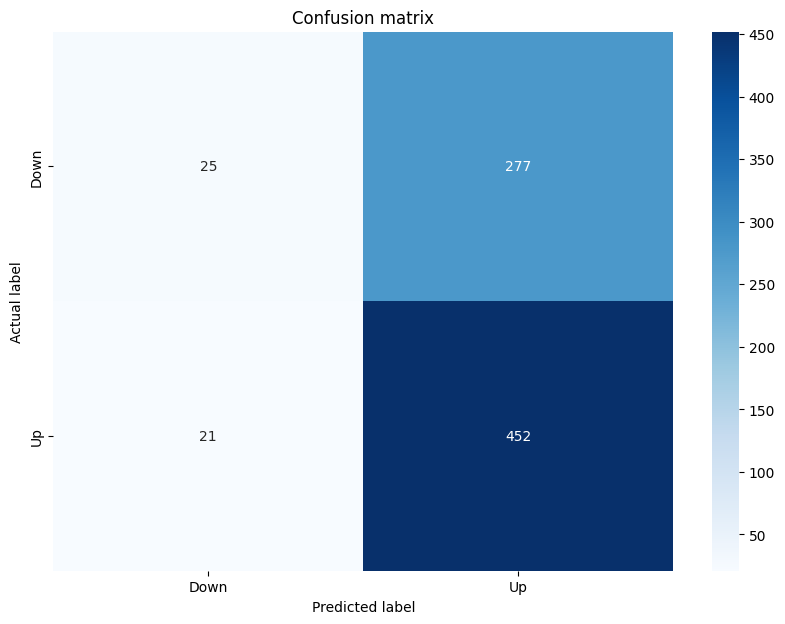

In [65]:
# Make predictions
y_pred_6_lstm=tuned_model_6_lstm.predict(X_test_6_lstm)

# create confustion matrix
fig, ax=plt.subplots(figsize=(10,7))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_6, y_pred_6_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])
plt.savefig('confusion_matrix_model_6_lstm.png', dpi=600)

print("Accuracy:",metrics.accuracy_score(y_test_6, y_pred_6_lstm))
print("Precision:",metrics.precision_score(y_test_6, y_pred_6_lstm))
print("Recall:",metrics.recall_score(y_test_6, y_pred_6_lstm))

775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


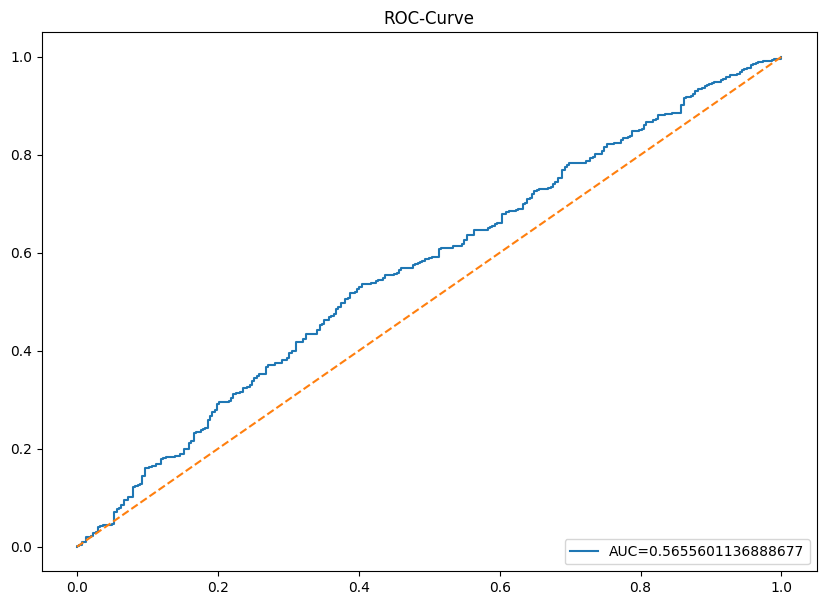

In [66]:
y_proba_6_lstm=tuned_model_6_lstm.predict_proba(X_test_6_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_6,  y_proba_6_lstm)
auc=metrics.roc_auc_score(y_test_6, y_proba_6_lstm)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.savefig('Roc_curve_model_6_lstm.png', dpi=600)